In [5]:
# todo remove unnecessary imports after code is completed
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
import time
import mpl_toolkits

In [6]:
# Define colors
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
GREEN = (0, 255, 0)
RED = (255, 0, 0)
BLUE = (0, 0, 255)

# Define constants
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 800

In [7]:
class Agent:
    def __init__(self, name, position, q_table, alpha, gamma, epsilon, world, policy=None):
        # Initialize variables with provided values
        self.name = name
        self.position = position
        self.q_table = q_table
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.world_bounds = (3,3,3)
        self.world = world

        # Initialize variables that track agent actions
        self.prev_state = None
        self.prev_action = None
        self.prev_reward = None
        self.carrying = None
        self.valid_actions = []
        self.best_path = []

    def reset(self):
        # Reset all states and rewards
        self.prev_reward = None
        self.prev_action = None
        self.prev_state = None
        self.carrying = None

    # Following functions move agent accordingly; checks if action is valid before moving
    def North(self):
        new_pos = (self.position[0], self.position[1] + 1, self.position[2])
        if self.is_valid_position(new_pos):
            self.position = new_pos

    def East(self):
        new_pos = (self.position[0] + 1, self.position[1], self.position[2])
        if self.is_valid_position(new_pos):
            self.position = new_pos

    def South(self):
        new_pos = (self.position[0], self.position[1] - 1, self.position[2])
        if self.is_valid_position(new_pos):
            self.position = new_pos

    def West(self):
        new_pos = (self.position[0] - 1, self.position[1], self.position[2])
        if self.is_valid_position(new_pos):
            self.position = new_pos

    def Up(self):
        new_pos = (self.position[0], self.position[1], self.position[2] + 1)
        if self.is_valid_position(new_pos):
            self.position = new_pos

    def Down(self):
        new_pos = (self.position[0], self.position[1], self.position[2] - 1)
        if self.is_valid_position(new_pos):
            self.position = new_pos

    # Checks if position is valid
    def is_valid_position(self, position):
        return all(0 <= coord < bound for coord, bound in zip(position, self.world_bounds))

    def pickup(self):
        if self.carrying is not None:
            print(f"{self.name} cannot pick up {self.carrying} as it is already carrying {self.carrying}")
            return

        item = self.world.get_item_at_position(self.position)
        if item is None:
            print(f"{self.name} cannot pick up an item as there is no item at its current position {self.position}")
            return

        if not self.world.is_item_pickupable(item):
            print(f"{self.name} cannot pick up {item} as it is not currently pickupable")
            return

        self.carrying = item
        self.world.remove_item_from_position(self.position)

        print(f"{self.name} picked up {item} at {self.position}")

    def dropoff(self):
        if self.carrying is None:
            print(f"{self.name} cannot drop off an item as it is not currently carrying anything")
            return

        if not self.world.is_item_dropoffable(self.carrying):
            print(f"{self.name} cannot drop off {self.carrying} as it is not currently droppable")
            return

        self.world.add_item_to_position(self.position, self.carrying)
        self.carrying = None

        print(f"{self.name} dropped off {self.carrying} at {self.position}")

    def get_next_action(self, world, policy):
        # Check if there is a valid pickup or dropoff action
        is_pickup_valid, is_dropoff_valid = world.get_valid_actions(self.position, self.carrying)

        # Get q-values for applicable actions
        q_values = {}
        for action in self.valid_actions:
            q_values[action] = self.q_table.get((self.position, self.carrying, action), 0)

        if policy == 'PRANDOM':
            # PRANDOM policy
            if is_pickup_valid or is_dropoff_valid:
                # Choose a random action
                return random.choice(['pickup', 'dropoff'] if is_pickup_valid and is_dropoff_valid else
                                     ['pickup'] if is_pickup_valid else ['dropoff'])
        elif policy == 'PEXPLOIT':
            # PEXPLOIT policy
            if q_values and random.random() < 0.85:
                # Choose the action with the highest q-value
                max_q_value = max(q_values.values())
                best_actions = [action for action, q_value in q_values.items() if q_value == max_q_value]
                return random.choice(best_actions)

        elif policy == 'PGREEDY':
            # PGREEDY policy
            if q_values:
                # Choose the action with the highest q-value
                max_q_value = max(q_values.values())
                best_actions = [action for action, q_value in q_values.items() if q_value == max_q_value]
                return random.choice(best_actions)

        else:
            # If no actions are applicable, choose a random action
            return random.choice(self.valid_actions)

    def store_best_path(self, state):
        self.best_path.append(state)

    def visualize_best_path(self):
        x, y, z = zip(*self.best_path)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, s=50, c='r', marker='o')
        ax.plot(x, y, z, 'b')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()

    def get_reward(self, new_state):
        # TODO edit reward values as necessary
        # Check if agent has picked up or dropped off an item
        if self.prev_action == 'pickup':
            # If agent picked up an item, reward is positive
            return 10
        elif self.prev_action == 'dropoff':
            # If agent dropped off an item at the target location, reward is positive
            if self.carrying == self.world.target:
                return 100
            # If agent dropped off an item at the wrong location, reward is negative
            else:
                return -50

        # If agent moved to a new location
        if new_state != self.prev_state:
            # Calculate distance between current position and target
            current_distance = abs(self.position[0] - self.world.target_pos[0]) + abs(self.position[1] - self.world.target_pos[1]) + abs(self.position[2] - self.world.target_pos[2])
            new_distance = abs(new_state[0] - self.world.target_pos[0]) + abs(new_state[1] - self.world.target_pos[1]) + abs(new_state[2] - self.world.target_pos[2])

            # If agent moved closer to the target, reward is positive
            if new_distance < current_distance:
                return 1
            # If agent moved away from the target, reward is negative
            else:
                return -1

        # If agent did not take any action, reward is 0
        return 0


In [8]:
class PDWorld:
    # Set up world for agents
    def __init__(self, size=(3, 3, 3), blocks=None, dropoffs=None):
        self.size = size
        self.blocks = {} if blocks is None else blocks
        self.dropoffs = {} if dropoffs is None else dropoffs

    def is_valid_position(self, position):
        return all(0 <= coord < bound for coord, bound in zip(position, self.size))

    # Returns value of block at given position
    def get_block(self, position):
        return self.blocks.get(position)

    # Sets value of block
    def set_block(self, position, value):
        self.blocks[position] = value

    # Removes block at given position
    def remove_block(self, position):
        self.blocks.pop(position, None)

    # Determine what actions agent can take
    def get_valid_actions(self, agent_pos, agent_holding):
        valid_actions = []

        # Agent can always stay in place
        valid_actions.append('stay')

        # Check if agent can move north
        if self.is_valid_position((agent_pos[0], agent_pos[1]+1, agent_pos[2])):
            valid_actions.append('north')

        # Check if agent can move east
        if self.is_valid_position((agent_pos[0]+1, agent_pos[1], agent_pos[2])):
            valid_actions.append('east')

        # Check if agent can move south
        if self.is_valid_position((agent_pos[0], agent_pos[1]-1, agent_pos[2])):
            valid_actions.append('south')

        # Check if agent can move west
        if self.is_valid_position((agent_pos[0]-1, agent_pos[1], agent_pos[2])):
            valid_actions.append('west')

        # Check if agent can move up
        if self.is_valid_position((agent_pos[0], agent_pos[1], agent_pos[2]+1)):
            valid_actions.append('up')

        # Check if agent can move down
        if self.is_valid_position((agent_pos[0], agent_pos[1], agent_pos[2]-1)):
            valid_actions.append('down')

        # Check if agent can pick up a block
        if not agent_holding and agent_pos in self.blocks:
            valid_actions.append('pickup')

        # Check if agent can drop off a block
        if agent_holding and agent_pos in self.dropoffs and self.dropoffs[agent_pos] == agent_holding:
            valid_actions.append('dropoff')

        return valid_actions

    # There's a bunch of issues with attempting to make the figure interactive but I can't be bothered to fix them cus it's a headache
    # Basically dont try rotating it too much or else it'll end up flickering or glitching out
    def plot_world(self, agents=None):
        %matplotlib notebook
        fig = plt.figure(figsize=(10, 10), dpi=100)
        ax = fig.add_subplot(111, projection='3d', proj_type='ortho')

        # Set limits for the plot
        ax.set_xlim3d(0, self.size[0]-1)
        ax.set_ylim3d(0, self.size[1]-1)
        ax.set_zlim3d(0, self.size[2]-1)

        # Set axis ticks to integers
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.zaxis.set_major_locator(plt.MaxNLocator(integer=True))

        # Plot the blocks
        if self.blocks:
            block_positions = list(self.blocks.keys())
            block_xs, block_ys, block_zs = zip(*block_positions)
            block_colors = ['r' if value is None else 'b' for value in self.blocks.values()]
            ax.scatter(block_xs, block_ys, block_zs, c=block_colors, marker='s', antialiased=True)

        # Plot the dropoffs
        if self.dropoffs:
            dropoff_positions = list(self.dropoffs.keys())
            dropoff_xs, dropoff_ys, dropoff_zs = zip(*dropoff_positions)
            ax.scatter(dropoff_xs, dropoff_ys, dropoff_zs, c='g', marker='o', antialiased=True)

        # Plot the agents
        if agents is not None:
            agent_positions = [agent.position for agent in agents]
            if agent_positions:
                agent_xs, agent_ys, agent_zs = zip(*agent_positions)
                ax.scatter(agent_xs, agent_ys, agent_zs, c='k', marker='^', antialiased=True)

        # Add interactivity to the plot
        is_clicked = False
        def on_mouse_press(event):
            nonlocal is_clicked
            is_clicked = True

        def on_mouse_release(event):
            nonlocal is_clicked
            is_clicked = False

        def on_mouse_move(event):
            nonlocal is_clicked

            if is_clicked:
                # Calculate the distance the mouse has moved
                dx = abs(event.x - on_mouse_move.last_x)
                dy = abs(event.y - on_mouse_move.last_y)

                # Only update the plot if the mouse has moved more than a certain threshold
                if dx > 3 or dy > 3:
                    # Update the azimuthal angle (azim) based on the mouse movement
                    azim = ax.azim - (event.xdata - on_mouse_move.last_x) / 2
                    if azim > 180:
                        azim -= 360
                    elif azim < -180:
                        azim += 360

                    # Smooth the azimuthal angle using a smoothing factor
                    smoothing_factor = 0.1
                    target_azim = azim
                    if on_mouse_move.target_azim is None:
                        on_mouse_move.target_azim = target_azim
                    else:
                        on_mouse_move.target_azim += smoothing_factor * (target_azim - on_mouse_move.target_azim)
                    ax.view_init(elev=ax.elev, azim=on_mouse_move.target_azim)

                    # Update the plot
                    fig.canvas.draw()
                    on_mouse_move.last_x = event.xdata
                    on_mouse_move.last_y = event.ydata

            else:
                on_mouse_move.last_x = event.xdata
                on_mouse_move.last_y = event.ydata

        on_mouse_move.last_x = None
        on_mouse_move.last_y = None
        on_mouse_move.target_azim = None

        fig.canvas.mpl_connect('button_press_event', on_mouse_press)
        fig.canvas.mpl_connect('button_release_event', on_mouse_release)
        fig.canvas.mpl_connect('motion_notify_event', on_mouse_move)

        plt.show()

        # Get the current view angle
        elev, azim = ax.elev, ax.azim

        # Adjust the limits of the plot based on the current view angle
        xmin, xmax = ax.get_xlim3d()
        ymin, ymax = ax.get_ylim3d()
        zmin, zmax = ax.get_zlim3d()

        r = 1.2 * max([xmax-xmin, ymax-ymin, zmax-zmin]) / 2

        xc = (xmax + xmin) / 2
        yc = (ymax + ymin) / 2
        zc = (zmax + zmin) / 2

        ax.set_xlim3d(xc - r, xc + r)
        ax.set_ylim3d(yc - r, yc + r)
        ax.set_zlim3d(zc - r, zc + r)

        # Update the plot
        fig.canvas.draw()



In [9]:
class QTable:
    def __init__(self, world_bounds, num_actions):
        self.table = {}
        self.world_bounds = world_bounds
        self.num_actions = num_actions

    # Returns q value for given state action pair from q table; default value is 0 if pair isn't present
    def get(self, state, action):
        return self.table.get((state, action), 0.0)

    # Updates q value for given state action pair with given value
    def update(self, state, action, value):
        self.table[(state, action)] = value

    # Returns action with highest q value for given state among list of actions; Randomizes action if there are multiple highest values
    def get_best_action(self, state, actions):
        q_values = {a: self.get(state, a) for a in actions}
        max_q = max(q_values.values())
        actions_with_max_q = [a for a, q in q_values.items() if q == max_q]
        return random.choice(actions_with_max_q)

    # Returns a list of valid actions for a given state
    def get_valid_actions(self, state, carrying):
        valid_actions = []
        x, y, z = state
        if carrying is None:
            # If agent is not carrying anything, pickup is valid if there is an item at the current location
            if self.table.get(((x, y, z), 'pickup'), None) is not None:
                valid_actions.append('pickup')
        else:
            # If agent is carrying something, dropoff is valid only at the target dropoff location
            if (x, y, z) == carrying.target_pos:
                valid_actions.append('dropoff')

        # Movement actions are always valid if they don't take the agent out of bounds
        if x < self.world_bounds[0] - 1:
            valid_actions.append('East')
        if x > 0:
            valid_actions.append('West')
        if y < self.world_bounds[1] - 1:
            valid_actions.append('North')
        if y > 0:
            valid_actions.append('South')
        if z < self.world_bounds[2] - 1:
            valid_actions.append('Up')
        if z > 0:
            valid_actions.append('Down')

        return valid_actions

    # Returns a list of all possible states in the 3D world
    def get_all_states(self):
        all_states = []
        for x in range(self.world_bounds[0]):
            for y in range(self.world_bounds[1]):
                for z in range(self.world_bounds[2]):
                    all_states.append((x, y, z))
        return all_states

    # Returns a list of all possible state-action pairs in the 3D world
    def get_all_state_action_pairs(self):
        all_states = self.get_all_states()
        all_actions = ['pickup', 'dropoff', 'East', 'West', 'North', 'South', 'Up', 'Down']
        state_action_pairs = []
        for state in all_states:
            valid_actions = self.get_valid_actions(state, None)
            for action in all_actions:
                if action in valid_actions:
                    state_action_pairs.append((state, action))
        return state_action_pairs


In [10]:
# Additional functions
def prevent_collision(agent1, agent2):
    # Agents are at the same position, so move one of them randomly
    if agent1.position == agent2.position:
        possible_moves = ['North', 'East', 'South', 'West', 'Up', 'Down']
        random_move = random.choice(possible_moves)
        if random_move == 'North':
            agent1.North()
        elif random_move == 'East':
            agent1.East()
        elif random_move == 'South':
            agent1.South()
        elif random_move == 'West':
            agent1.West()
        elif random_move == 'Up':
            agent1.Up()
        elif random_move == 'Down':
            agent1.Down()

In [11]:
# initializing world
WORLD_SIZE = 3 # alter as necessary
world = PDWorld(size=(WORLD_SIZE, WORLD_SIZE, WORLD_SIZE))
world.set_block((1,1,1), 'block1')
agentM = Agent(name='M', position=(0, 0, 0), q_table=None, alpha=0.1, gamma=0.9, epsilon=0.1, world=world)
agentF = Agent(name='F', position=(2, 2, 2), q_table=None, alpha=0.1, gamma=0.9, epsilon=0.1, world=world)
agents = [agentF, agentM]

<IPython.core.display.Javascript object>


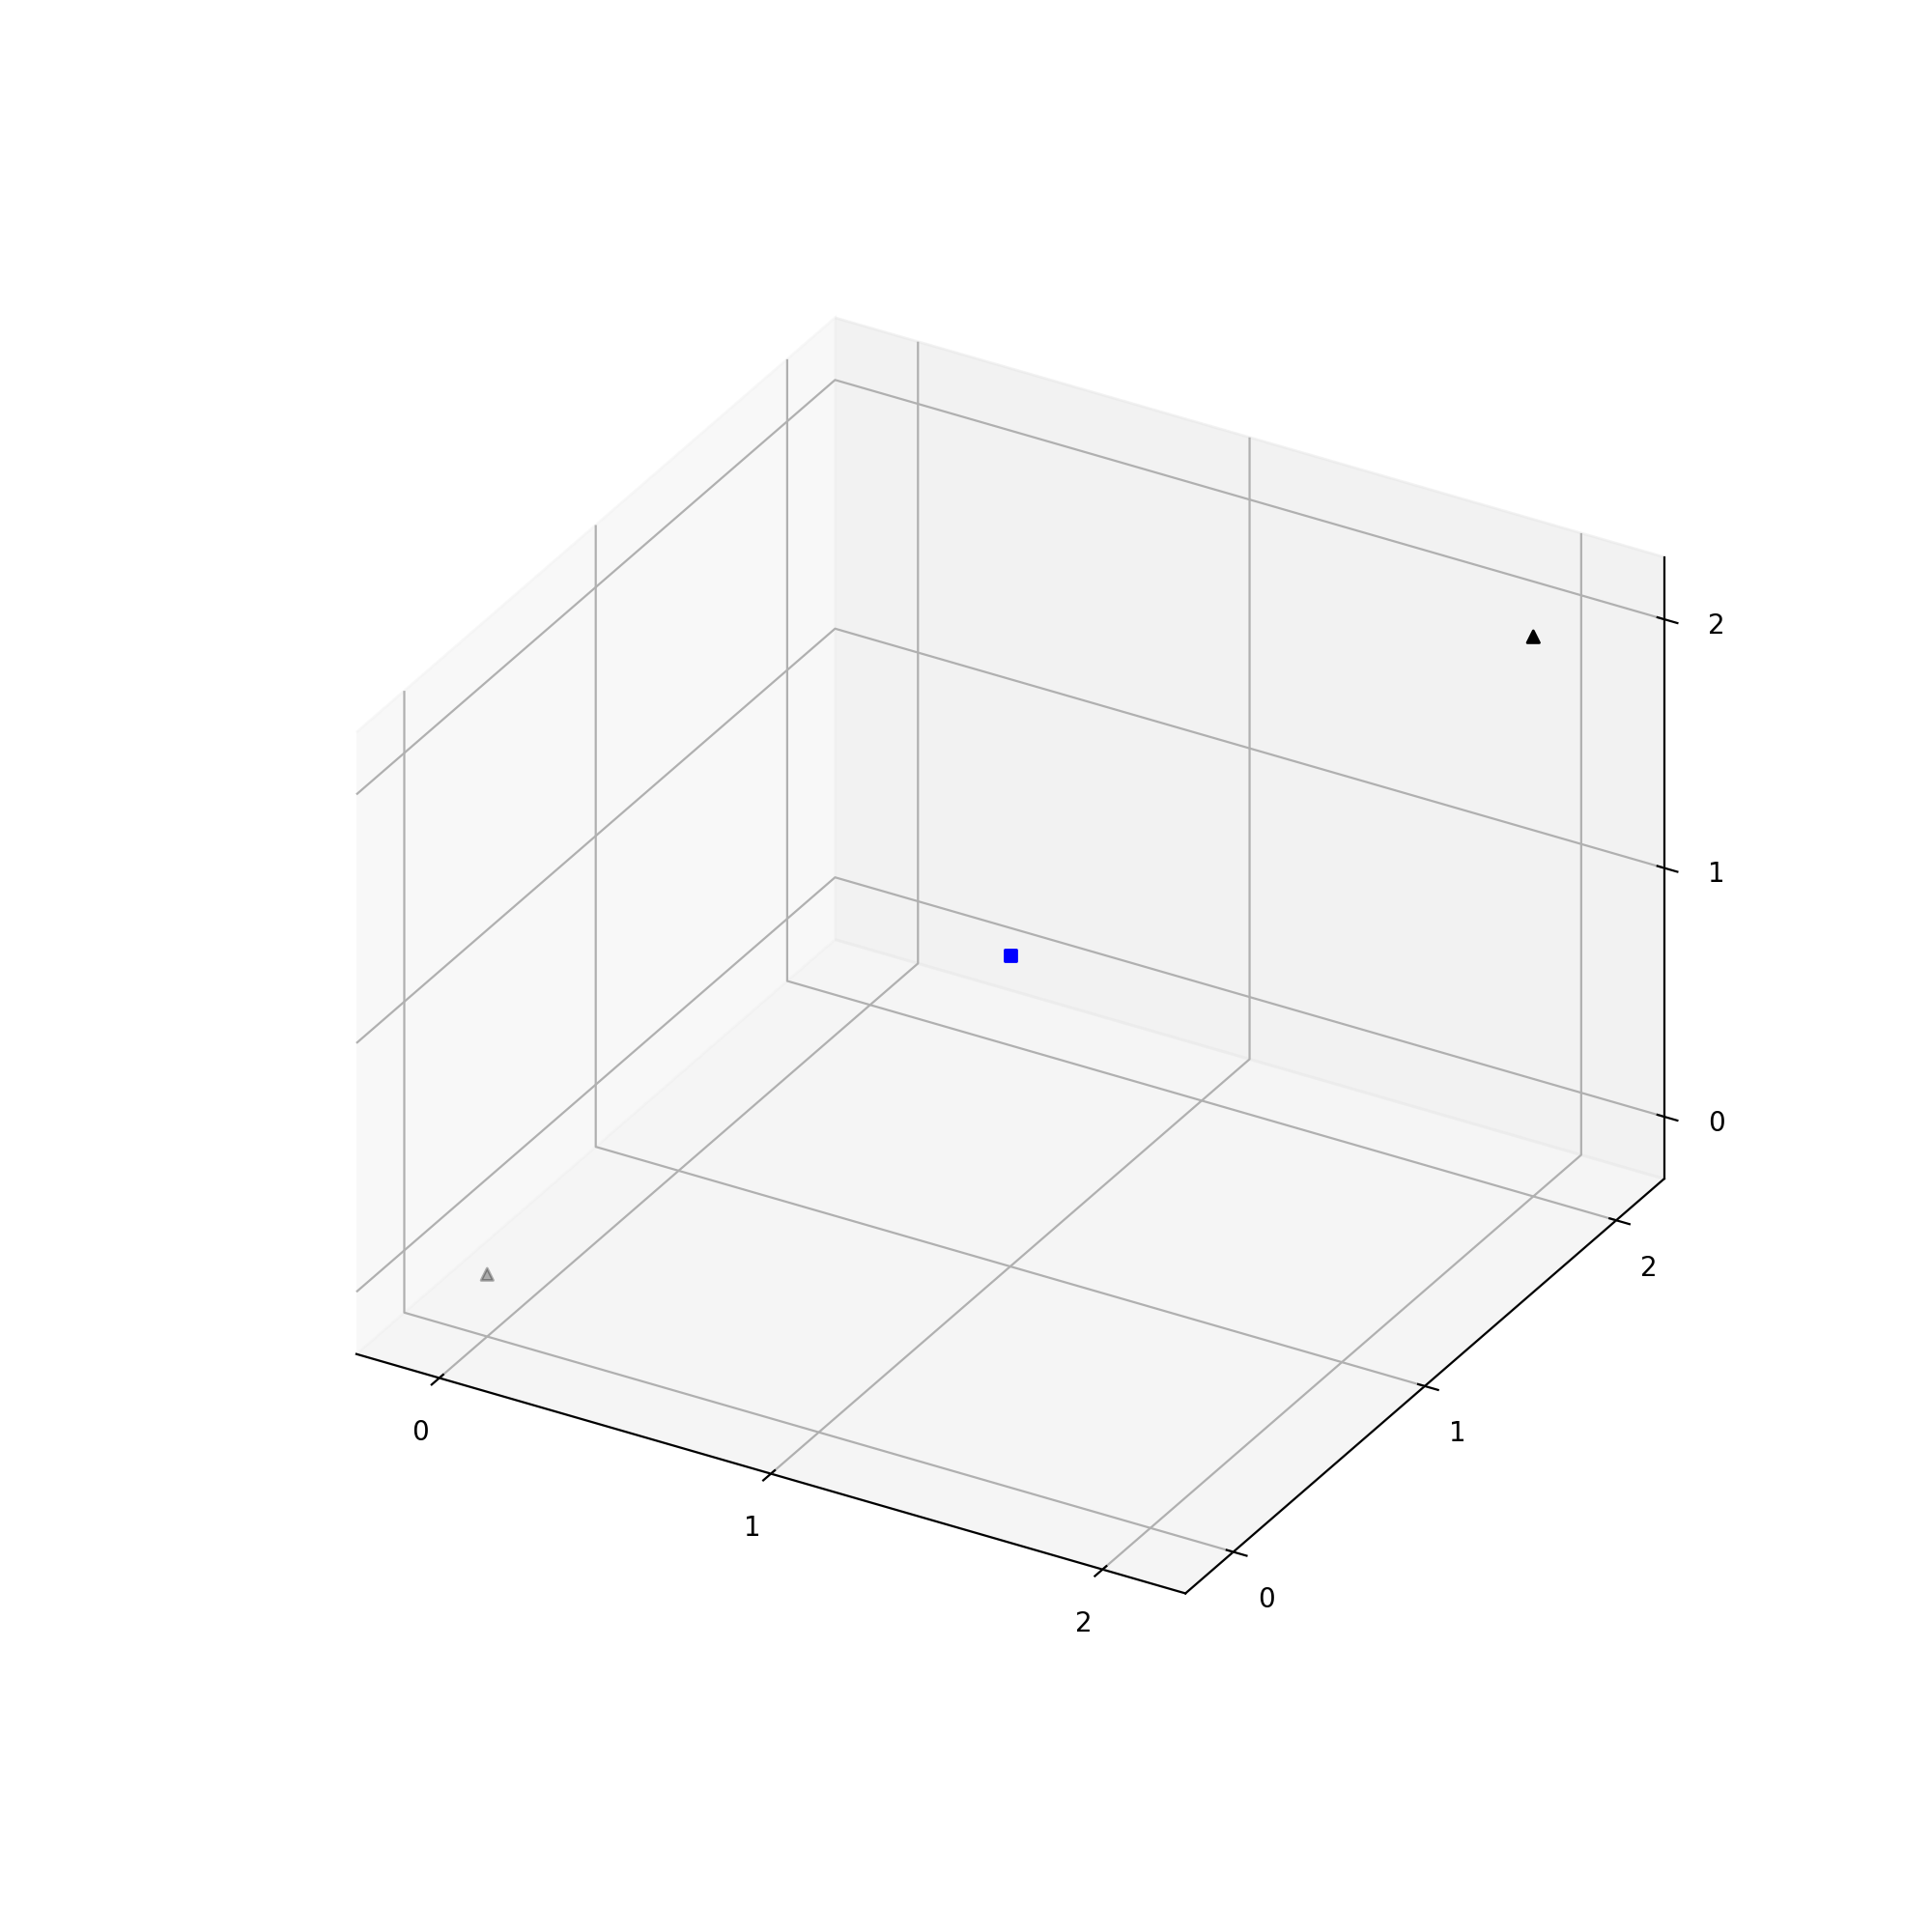

In [12]:
world.plot_world(agents)

<IPython.core.display.Javascript object>


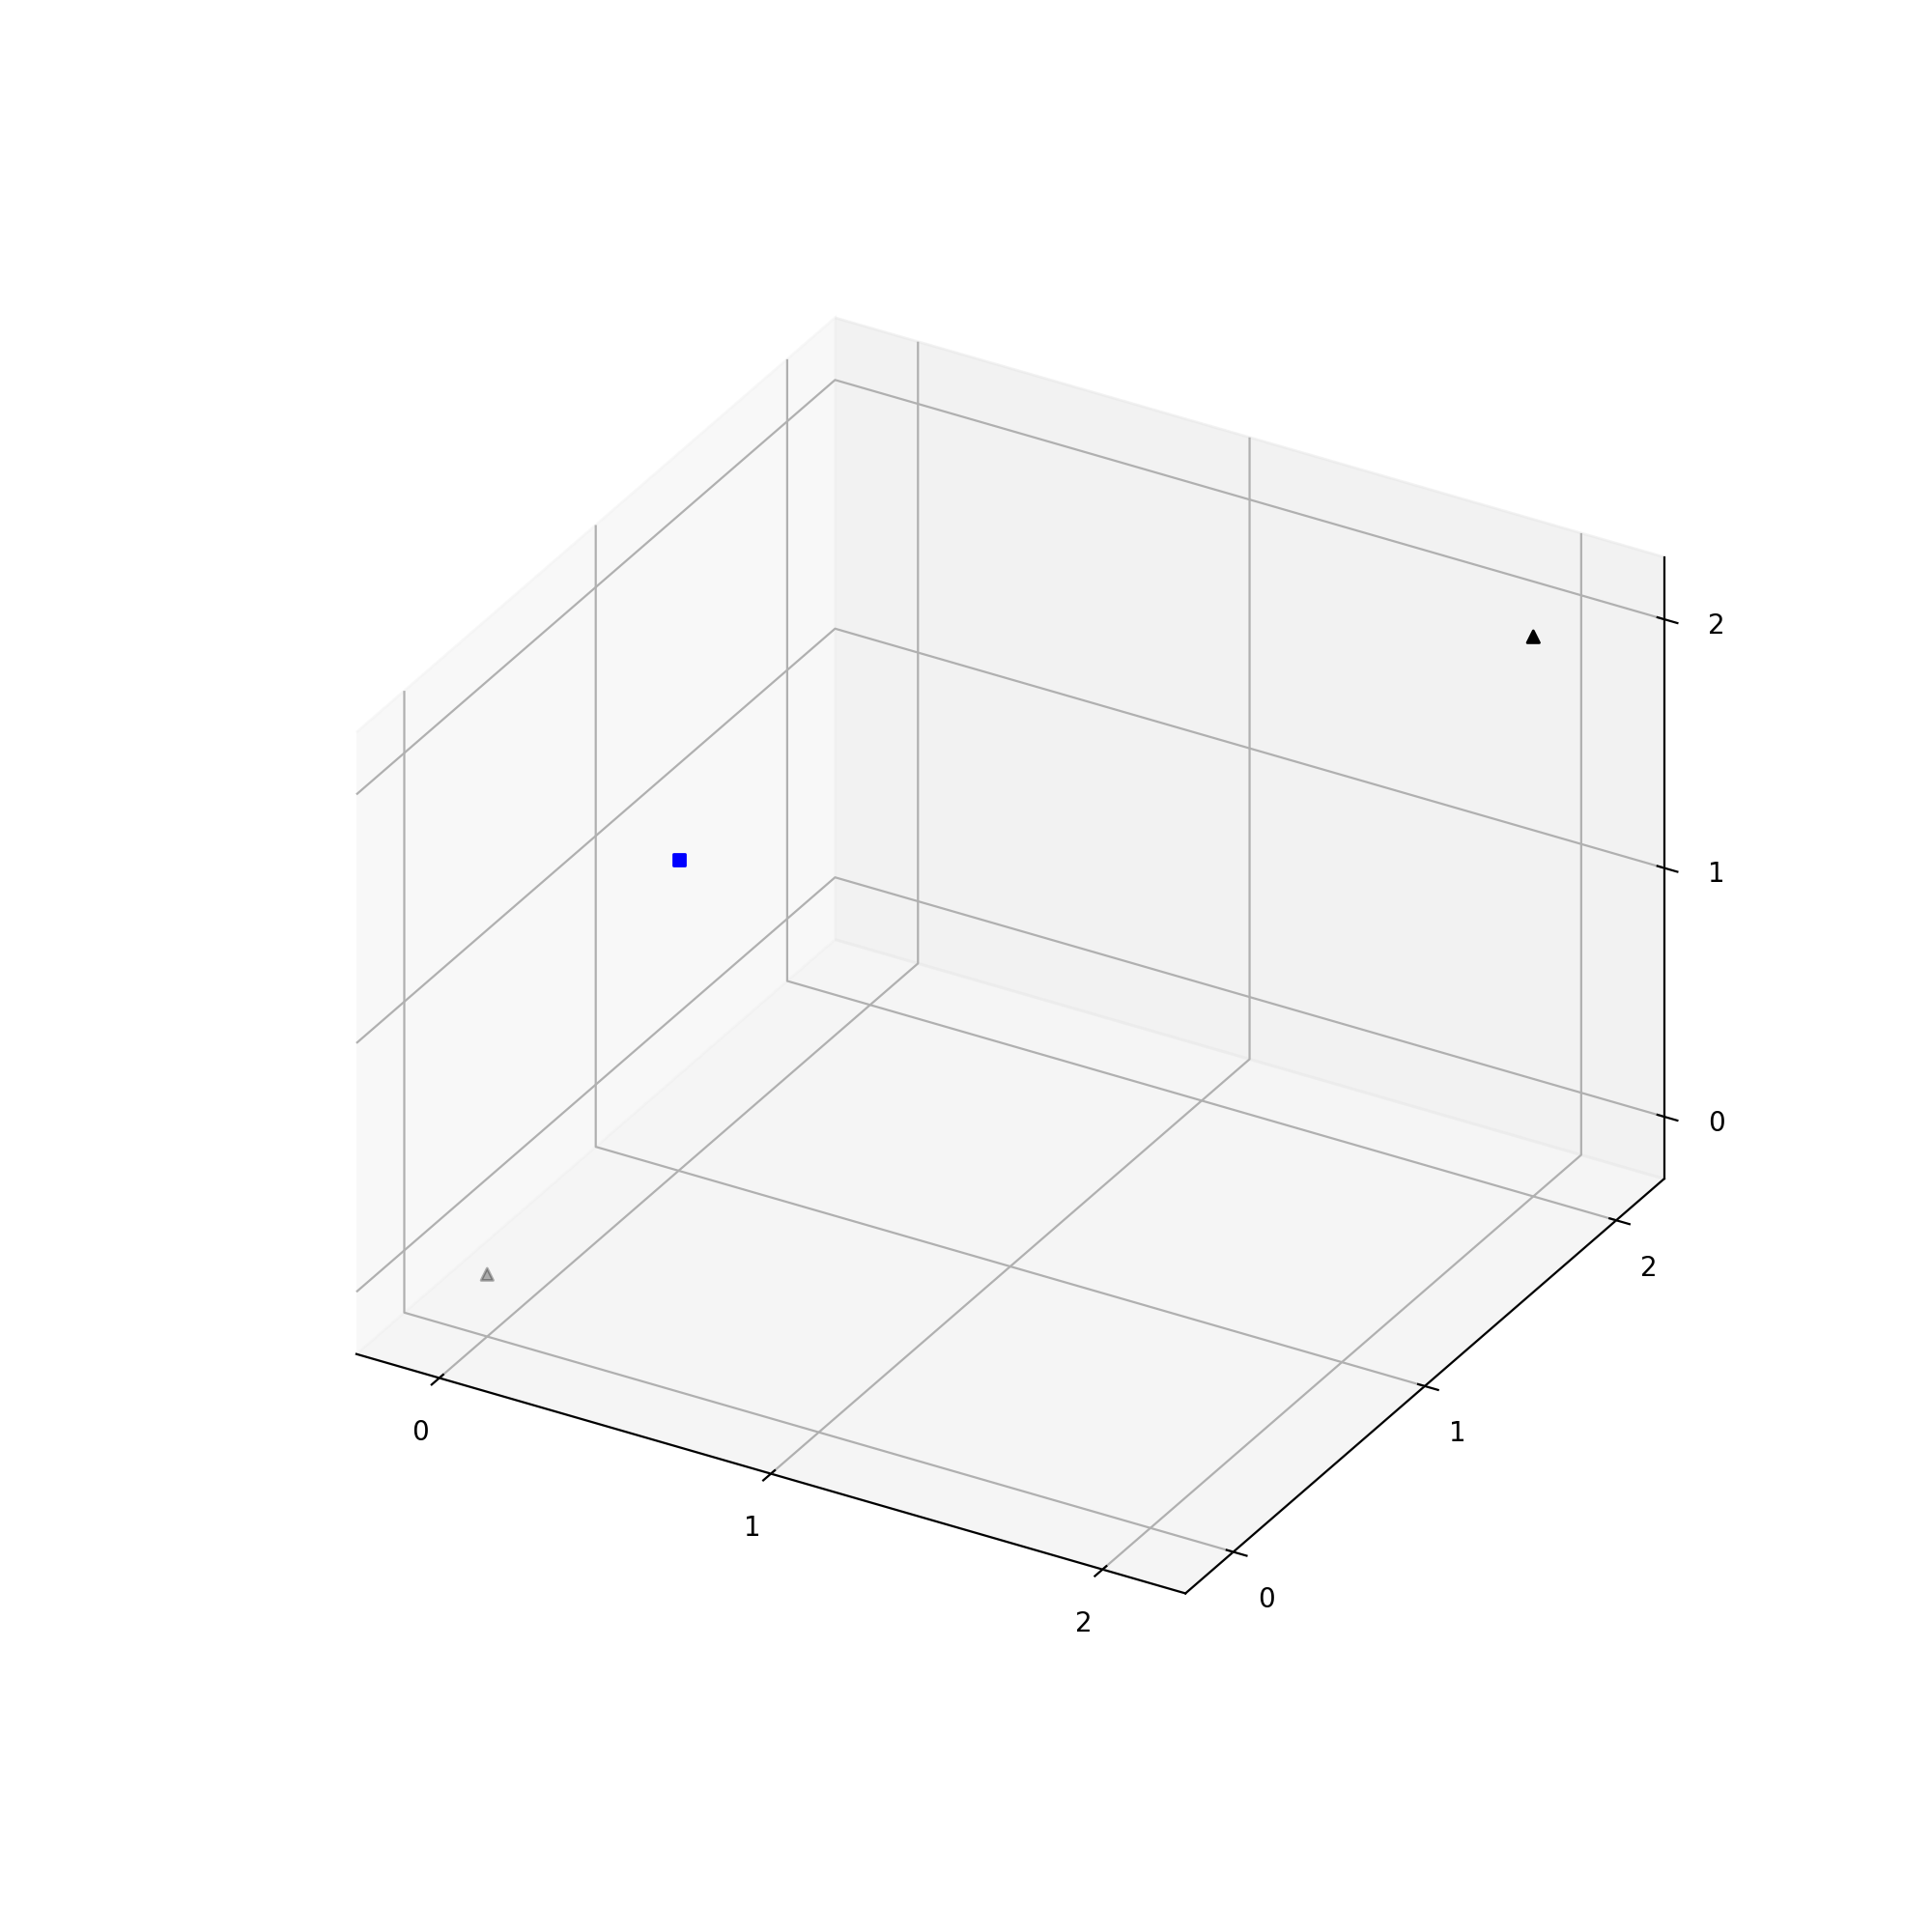

In [13]:
# example of how to initialize agents with different policies
WORLD_SIZE = 3 # alter as necessary
world = PDWorld(size=(WORLD_SIZE, WORLD_SIZE, WORLD_SIZE))
world.set_block((0,1,1), 'block1')
agentM = Agent(name='M', position=(0, 0, 0), q_table=None, alpha=0.1, gamma=0.9, epsilon=0.1, world=world, policy='PRANDOM')
agentF = Agent(name='F', position=(2, 2, 2), q_table=None, alpha=0.1, gamma=0.9, epsilon=0.1, world=world, policy='PRANDOM')
agents = [agentF, agentM]
world.plot_world(agents)

In [ ]:
# From here I'm trying to make a traditional Q algorithm, I am actually very confused on why its not working well

In [25]:
#initialize Qtable size of place + number of ways it can move
def initialize_q_table(state_space, action_space):
    
    Qtable = np.zeros((state_space, action_space))
    return Qtable

In [26]:
# Creates a greedy policy to decide where to go
def epsilon_greedy_policy(Qtable, state, epsilon):
    random_int = random.uniform(0,1)
    if random_int > epsilon:
        action = np.argmax(Qtable[state])
    else:
        action = world.action_space.sample()
    return action

In [27]:
def greedy_policy(Qtable, state):
    action = np.argmax(Qtable[state])
    return action

In [28]:
# Trying to see if the training will come in

#training parameters
n_training_episode = 10000
learning_rate = 0.3

#Evaluation paramter

n_eval_episodes = 100

#Evnironment parameter

max_steps = 99
gamma = 0.95
eval_seed = []

#Exploreation parameters

max_epsilon = 1.0
min_epsilon = 0.05
decay_rate = 0.005

In [29]:
#lets see about training man idk how this will go honestly

def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
    
    #reset
    
    state = env.reset()
    step = 0
    done = False
    
    #repeat repeat
    
    for step in range(max_steps):
        
        action = epsilon_greedy_policy(Qtable, state, epsilon)
        
        new_state, reward, done, info = env.step(action)
        
        Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma + np.max(Qtable[new_state]) - Qtable[state][action])
        
        #if somehow done finish it
        
        if done:
            break
        
        state = new_stae
    return Qtable

In [30]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
    
    episode_rewards = []
    
    for episode in range(n_eval_episodes):
        
        if seed:
            
            state = env.reset(seed = seed[episode])
        else:
            
            state = envv.reset()
            
        step = 0
        done = False
        total_rewards_ep = 0
        
        for step in range(max_steps):
            action = np.argmax(Q[state][:])
            new_state, reward, done, info = env.step(action)
            total_rewards_ep += reward
        
        if done:
            break
            
        state = new_state
    episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    
    return mean_reward, std_reward




#evaluate

mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_3d, eval_seed)

NameError: name 'env' is not defined

In [ ]:
#Right here I'm trying to SARSA 

In [21]:
def choose_action(state):
    action = 0
    
    if np.random.uniform(0, 1) < epsilon:
        
        action = env.action_space.ample()
        
    else:
        
        action = np.argmax(Qtable[state, :])
    
    return action

In [22]:
def update(state, state2, reward, action, action2):
    
    predict = Qtable[state, action]
    
    target = reward + gamma * Q[state2, action2]
    
    Qtable[state, action] = Qtable[state, action]
    

In [24]:
#SARSA actual learning wow crazy I hope this works actually
reward = 0

for episode in range(total_episodes):
    
    t = 0
    state1 = env.reset()
    action1 = choose_action(state1)
    
    while t < max_steps:
        
        state2, reward, done, info = env.step(action1)
        
        action2 = choose_action(state2)
        
        update(state1, state2, reward, action1, action2)
        
        state1 = state2
        action1 = action2
        
        t += 1
        reward += 1
        
        if done:
            break

NameError: name 'total_episodes' is not defined